
<h5>

學號：711133116

系級：統計碩一

姓名：周琦雅
<h5>

---

<h5>

本作品基於PyTorch的 SRCNN 模型進行高解析度影像生成的訓練，分成以下三個部份進行探討：

* 第一部分，讀入預訓練的pth檔並利用殘差的影像進行3次訓練，同時記錄Train PSNR和Val PSNR值。

* 第二部份，測試Set5和Set14資料集，將輸出的影像加上原圖後，再計算Test PSNR on Set5和Test PSNR on Set14的結果。

* 最後一部分，將一張影像輸入已訓練完成的 SRCNN 模型，並生成對應的高解析度影像。
</h5>

---



#  **pre-trained 的程式碼說明**
---
<h5>

* 在一開始的 patchify_image.py 的程式碼中，利用 patch 與 high_res_upscale 計算出殘差，並將其標準化。通過減去最小值，並將結果除以殘差的範圍（最大值減最小值），將值縮放到0到255的範圍內。最後，將結果轉換為uint8類型。

* 模型的主幹部分由一系列卷積層和ReLU激活函數組成。首先，通過一個3通道到64通道的卷積層對輸入圖像進行特徵提取。然後，特徵圖通過5個內部的ConvReLU模塊進行進一步的特徵提取和非線性變換。每個ConvReLU模塊都包含一個64通道的卷積層和ReLU激活函數。接下來，通過一個64通道到3通道的卷積層對特徵圖進行解碼，並生成最終的高解析度圖像。最後，將最終輸出與輸入圖像相加，以保留低頻細節，確保生成的高解析度圖像保留了原始圖像的細節特徵。

* 在 train 的程式碼中，利用殘差的圖片作為 train_label ，並使用SGD優化器(lr = 0.1、momentum = 0.9、weight_decay = 0.9、nesterov = False、max_norm = 1)和MSE損失函數對模型進行訓練。在訓練過程中。此外還創建了一個StepLR的學習率調整器scheduler = StepLR(optimizer, step_size=10, gamma=0.1) ，用來更新優化器的學習率，幫助模型更好地收斂或避免overfitting。
<h5>

---

In [113]:
import torch
import glob as glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from srcnn import SRCNN
from srcnn import ConvReLU
from PIL import Image
from utils import psnr
from torch.utils.data import DataLoader, Dataset
import os
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#  **第一部分**

In [114]:
import time
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
from datasets import get_datasets, get_dataloaders

<h3> 讀入 pre-trained 的 pth 檔

In [116]:
%run srcnn.py
# Constants
TRAIN_LABEL_PATHS = 'E:/淺度機器學習/hw4_data/input/t91_res'
TRAN_IMAGE_PATHS = 'E:/淺度機器學習/hw4_data/input/t91_lr_patches'
VALID_LABEL_PATHS = 'E:/淺度機器學習/hw4_data/input/test_hr'
VALID_IMAGE_PATHS = 'E:/淺度機器學習/hw4_data/input/test_bicubic_rgb_2x'
SAVE_VALIDATION_RESULTS = False

# Initialize the model.
print('Computation device: ', device)
model = SRCNN().to(device)
model.load_state_dict(torch.load('E:/淺度機器學習/hw4_data/outputs/model.pth'))


Computation device:  cpu


<All keys matched successfully>

<h3>根據 pre-trained 的結果，將 epoch 設為 15，再進行 3 次 training，並展示其  Train PSNR 與 Val PSNR 值。


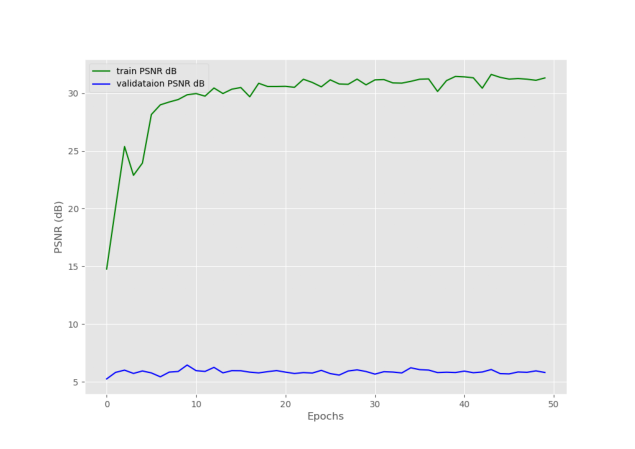

In [197]:
fig = plt.figure(figsize=[16, 8])
import matplotlib.image as mpimg
image = mpimg.imread("E:\\淺度機器學習\\hw4_data\\outputs_50\\psnr.png")
plt.imshow(image)
plt.axis('off')
plt.show()

In [117]:
lr= 0.1
momentum= 0.9
weight_decay = 1e-4
nesterov = False
max_norm = 1.0

# Optimizer.
optimizer = optim.SGD(model.parameters(),
                      lr=lr,
                      momentum= momentum,
                      weight_decay= weight_decay,
                      nesterov= nesterov)
# Loss function. 
criterion = nn.MSELoss()

dataset_train, dataset_valid = get_datasets(
    TRAN_IMAGE_PATHS, TRAIN_LABEL_PATHS,
    VALID_IMAGE_PATHS, VALID_LABEL_PATHS
)
train_loader, valid_loader = get_dataloaders(dataset_train, dataset_valid)

print(f"Training samples: {len(dataset_train)}")
print(f"Validation samples: {len(dataset_valid)}")

def train(model, dataloader):
    model.train()
    running_loss = 0.0
    running_psnr = 0.0
    for bi, data in tqdm(enumerate(dataloader), total=len(dataloader)):
        image_data = data[0].to(device)
        label = data[1].to(device)
        
        # Zero grad the optimizer.
        optimizer.zero_grad()
        outputs = model(image_data)
        loss = criterion(outputs, label)

        # Backpropagation.
        loss.backward()
        # Update the parameters.
        optimizer.step()

        # Add loss of each item (total items in a batch = batch size).
        running_loss += loss.item()
        # Calculate batch psnr (once every `batch_size` iterations).
        batch_psnr =  psnr(label, outputs)
        running_psnr += batch_psnr

    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/len(dataloader)
    return final_loss, final_psnr


def validate(model, dataloader, epoch=15):
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(dataloader), total=len(dataloader)):
            image_data = data[0].to(device)
            label = data[1].to(device)
            
            outputs = model(image_data)
            loss = criterion(outputs, label)

            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            # Calculate batch psnr (once every `batch_size` iterations).
            batch_psnr = psnr(label, outputs)
            running_psnr += batch_psnr


    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/len(dataloader)
    return final_loss, final_psnr



os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
epoch=15
for i in range(3):
    train_loss, val_loss = [], []
    train_psnr, val_psnr = [], []
    start = time.time()
    
    print(i+1,"of 3")
    train_epoch_loss, train_epoch_psnr = train(model, train_loader)
    val_epoch_loss, val_epoch_psnr = validate(model, valid_loader, epoch+1)
    print(f"Train PSNR: {train_epoch_psnr:.3f}")
    print(f"Val PSNR: {val_epoch_psnr:.3f}")
    train_loss.append(train_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    val_loss.append(val_epoch_loss)
    val_psnr.append(val_epoch_psnr)

    end = time.time()
    print(f"Finished training in: {((end-start)/60):.3f} minutes")

  0%|          | 0/174 [00:00<?, ?it/s]

Training samples: 22227
Validation samples: 14
1 of 3


  0%|          | 0/174 [00:00<?, ?it/s]

Train PSNR: 28.597
Val PSNR: 5.468
Finished training in: 8.100 minutes
2 of 3


  0%|          | 0/174 [00:00<?, ?it/s]

Train PSNR: 29.205
Val PSNR: 5.928
Finished training in: 7.681 minutes
3 of 3


100%|██████████| 14/14 [00:19<00:00,  1.41s/it]

Train PSNR: 27.279
Val PSNR: 5.949
Finished training in: 7.556 minutes


# **第一部份觀察結果**
<h5>上述程式碼為利用原圖與 label 的殘差所建立好的 SRCNN 模型，可以從三次的 Train PSNR 與 Val PSNR 結果中發現，當epoch=15 時 Train PSNR 的值約在30左右，而 Val PSNR 的值會較低是因為 train_label 資料集為殘差的數據特徵，因此輸出的圖片也只會有殘差的部份，且尚未與原圖進行加總，所以會有正樣的情況也是正常的。

# **第二部份**
<h3>測試 Set5 與 Set14 並展示 Test PSNR on Set5 與 Test PSNR on Set14。

In [140]:
def validate(model, dataloader, device):
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(dataloader), total=len(dataloader)):
            
            image_data = data[0].to(device)
            label = data[1].to(device)
            
            outputs = model(image_data)

            # Calculate batch psnr (once every `batch_size` iterations).
            batch_psnr = psnr(label, outputs+image_data)
            running_psnr += batch_psnr

    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/len(dataloader)
    return final_loss, final_psnr

# The SRCNN dataset module.
class SRCNNDataset(Dataset):
    def __init__(self, image_paths):
        self.all_image_paths = glob.glob(f"{image_paths}/*")

    def __len__(self):
        return (len(self.all_image_paths))

    def __getitem__(self, index):
        # The high resolution ground truth label.
        label = Image.open(self.all_image_paths[index]).convert('RGB')
        w, h = label.size[:]
        # Convert to 2x bicubic.
        low_res_img = label.resize((int(w*0.5), int(h*0.5)), Image.BICUBIC)
        # The low resolution input image.
        image = low_res_img.resize((w, h), Image.BICUBIC)

        # Uncomment the below code to visualize the image for sanity check.
        '''
        if index ==3:
            plt.figure(figsize=(12, 9))
            plt.subplot(1, 2, 1)
            plt.imshow(image) #原圖放大
            plt.axis('off')
            plt.subplot(1, 2, 2)
            plt.imshow(label) #srcnn
            plt.axis('off')
            plt.show()
        '''
        
        image = np.array(image, dtype=np.float32)
        label = np.array(label, dtype=np.float32)

        image /= 255.
        label /= 255.

        image = image.transpose([2, 0, 1])
        label = label.transpose([2, 0, 1])

        return (
            torch.tensor(image, dtype=torch.float), #原圖放大
            torch.tensor(label, dtype=torch.float) #srcnn
        )

# Prepare the datasets.
def get_datasets(
    image_paths
):
    dataset_test = SRCNNDataset(image_paths)
    return dataset_test

# Prepare the data loaders
def get_dataloaders(dataset_test):
    test_loader = DataLoader(
        dataset_test, 
        batch_size=1,
        shuffle=False
    )
    return test_loader


In [133]:
%run srcnn.py

In [96]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
if __name__ == '__main__':
    # Load the model.
    model = SRCNN().to(device)
    model.load_state_dict(torch.load('E:/淺度機器學習/hw4_data/outputs/model.pth'))

    data_paths = [
        ['../input/Set5/original', 'Set5'],
        ['../input/Set14/original', 'Set14']
    ]

    for data_path in data_paths: #data_path[0]路徑,[1]檔名
        dataset_test = get_datasets(data_path[0])
        test_loader = get_dataloaders(dataset_test)

        _, test_psnr = validate(model, test_loader, device)
        print(f"Test PSNR on {data_path[1]}: {test_psnr:.3f}")

  0%|          | 0/14 [00:00<?, ?it/s]

Test PSNR on Set5: 30.606


100%|██████████| 14/14 [00:21<00:00,  1.56s/it]

Test PSNR on Set14: 27.873


# **第二部份觀察結果**
<h5>如同第一部份所述，要將模型所訓練出來的殘差圖加上原圖再計算 psnr 才是合理的，因此在 validate 的程式中將 outputs 加上 image_data。從此結果可以發現，Set5 和 Set14 的 pnsr 值(30、27.8)與 train pnsr 的值相當接近，表示模型的輸出相當穩定。

# **第三部份**
<h3>實際對已訓練完成的 CNN 模型輸入任何一張影像，並生成相對應的一張高解度影像。

In [90]:
import cv2
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import matplotlib.patches as patches

In [200]:
model = SRCNN().to(device)
model.load_state_dict(torch.load('E:/淺度機器學習/hw4_data/outputs/model.pth'))

#原圖
original_img = cv2.imread('../input/Set14/original/Dog.png')
original_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR)
original_tensor = torch.from_numpy(original_img).permute(2, 0, 1).unsqueeze(0).float() / 255.0

# 讀取圖片bicubic縮小後放大,Reshape成(1,3,w,h)
bicubic_img = cv2.imread('../input/test_bicubic_rgb_2x/Dog.png')
bicubic_img = cv2.cvtColor(bicubic_img, cv2.COLOR_RGB2BGR)
bicubic_tensor = torch.from_numpy(bicubic_img).permute(2, 0, 1).unsqueeze(0).float() / 255.0
bicubic_tensor = bicubic_tensor.to(device)

#殘差圖
output_res = model(bicubic_tensor)
#加上原圖
output = output_res + original_tensor

# 轉換回NumPy數組
output_img = output.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


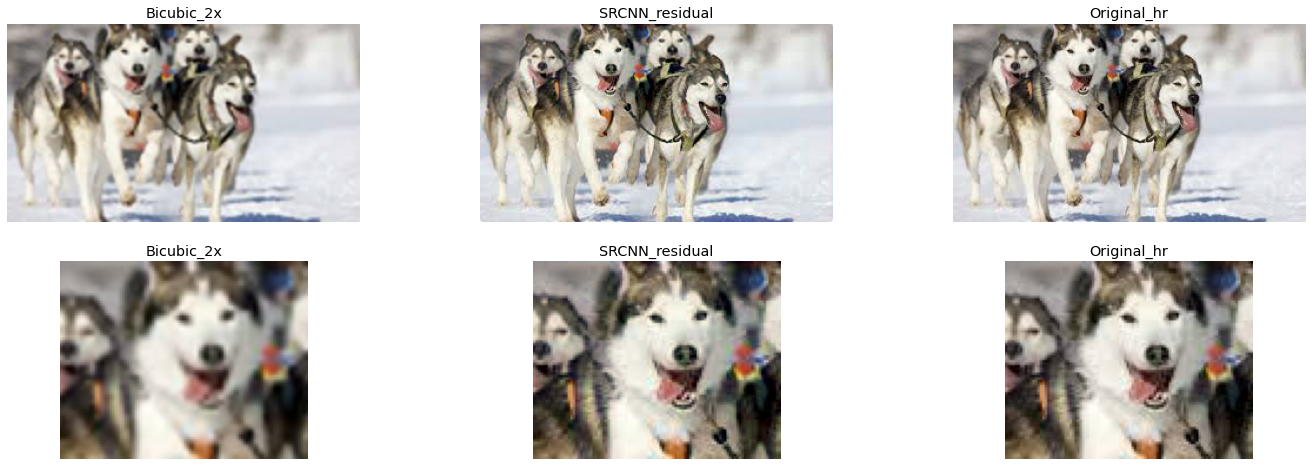

In [230]:
hr_img = cv2.imread('../input/test_hr/Dog.png')
hr_img = cv2.cvtColor(hr_img, cv2.COLOR_RGB2BGR)

imgs=[bicubic_img,output_img,hr_img]
imgs_name = ["Bicubic_2x","SRCNN_residual","Original_hr"]
fig = plt.figure(figsize=[24, 8])
ax = fig.subplots(2, 3)

for i in range(len(imgs)):
    ax[0][i].imshow(imgs[i])
    ax[0][i].set_axis_off()
    ax[0][i].set_title(imgs_name[i])

for i in range(len(imgs)):
    selected_region = imgs[i][0:80,50:150]  
    ax[1][i].imshow(selected_region)
    ax[1][i].axis('off')
    ax[1][i].set_title(imgs_name[i])


# **計算 PSNR**

In [203]:
running_psnr = 0.0
batch_psnr = psnr(output, output+original_tensor)
running_psnr += batch_psnr
print(f"Test PSNR : {test_psnr:.3f}")

Test PSNR : 30.258


# **觀察與心得**
<h5>

* 在利用殘差訓練模型之前，我也有嘗試過單純用放大兩倍的圖片做訓練過(epoch=300)，發現用殘差做訓練的時間縮短了將近兩倍，且 pnsr 的值也是相近的。在訓練模型時，發現模型在 epoch=15 的時候 pnsr 的值會到達30左右，也發現對於此資料集不需要太深的模型，ConvReLu 的層數增加並不會讓 pnsr 上升，反而會下降。

* 經過這次作業的訓練後，除了讓我對繼承的程式設計方法更加熟悉之外，也使我在這短短的兩個禮拜，磨練出更好的耐心，並且變得更加細心，無論是對於資料還是對於模型，都能更加有效率地摸索它們的型態，相信在未來面對更複雜的模型或者資料時，我也能根據這次的經驗一步一步的達到心中所期待的結果。
